In [ ]:
# VaR for a portfolio of FNZ.NZ (nzx top 50) and VOO (vanguard s&p 500)
# take into account exchange rate for VOO investment

In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns   #seaborn is a nice skin for matplotlib
sns.set()
from tabulate import tabulate
from IPython.display import display

# Get Data

In [3]:
# define symbols
tickers = ['FNZ.NZ', 'VOO', 'NZDUSD=X']

# define data range to extract data from
start_date = datetime.today() - timedelta(days = 365*10)    # roughly 10 years ago. Not exact same date, but good enough. Need extra dates to fillna values anyway
end_date = datetime.today()
display(start_date, end_date)

datetime.datetime(2012, 10, 23, 10, 14, 30, 776866)

datetime.datetime(2022, 10, 21, 10, 14, 30, 776866)

## Extract

In [33]:
# get data from pandas_datareader. Source = yahoo finance
data = pdr.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
data.head()

Attributes Adj Close                        Close                        \
Symbols       FNZ.NZ         VOO  NZDUSD=X FNZ.NZ         VOO  NZDUSD=X   
Date                                                                      
2012-10-21       NaN         NaN  0.815727    NaN         NaN  0.815727   
2012-10-22     1.445  109.065987  0.818331  1.445  131.320007  0.818331   
2012-10-23     1.440  107.471352  0.811227  1.440  129.399994  0.811227   
2012-10-24     1.440  107.238785  0.820681  1.440  129.119995  0.820681   
2012-10-25     1.440  107.537796  0.819941  1.440  129.479996  0.819941   

Attributes   High                          Low                         Open  \
Symbols    FNZ.NZ         VOO  NZDUSD=X FNZ.NZ         VOO  NZDUSD=X FNZ.NZ   
Date                                                                          
2012-10-21    NaN         NaN  0.819202    NaN         NaN  0.815727    NaN   
2012-10-22  1.445  131.500000  0.818398  1.442  130.259995  0.810373  1.444   
2012-10-23  1.444  130.039993  0.816527  1.437  128.960007  0.811162  1.440   
2012-10-24  1.443  130.100006  0.824470  1.430  128.919998  0.820143  1.440   
2012-10-25  1.440  130.240005  0.823927  1.437  128.720001  0.817194  1.437   

Attributes                          Volume                     
Symbols            VOO  NZDUSD=X    FNZ.NZ       VOO NZDUSD=X  
Date                                                           
2012-10-21         NaN  0.815727       NaN       NaN      0.0  
2012-10-22  131.080002  0.818398  167581.0  503500.0      0.0  
2012-10-23  129.919998  0.811162  101293.0  519000.0      0.0  
2012-10-24  129.899994  0.821085   82272.0  365650.0      0.0  
2012-10-25  130.080002  0.819605   34422.0  485500.0      0.0

In [34]:
# take adjusted close only
display(data['Adj Close'].head())
display(data['Adj Close'].tail())

Symbols,FNZ.NZ,VOO,NZDUSD=X
Date,,,
2012-10-21,NaN,NaN,0.815727
2012-10-22,1.445,109.065987,0.818331
2012-10-23,1.440,107.471352,0.811227
2012-10-24,1.440,107.238785,0.820681
2012-10-25,1.440,107.537796,0.819941


Symbols,FNZ.NZ,VOO,NZDUSD=X
Date,,,
2022-10-13,2.932,336.220001,0.563911
2022-10-14,NaN,328.649994,NaN
2022-10-16,2.905,NaN,0.557600
2022-10-17,NaN,337.000000,0.565668
2022-10-18,2.918,340.970001,0.569022


## Clean

In [35]:
# fillna with value of the previous day
ClosePrice = data['Adj Close'].fillna(method="ffill")
display(ClosePrice.head())
display(ClosePrice.tail())

Symbols,FNZ.NZ,VOO,NZDUSD=X
Date,,,
2012-10-21,NaN,NaN,0.815727
2012-10-22,1.445,109.065987,0.818331
2012-10-23,1.440,107.471352,0.811227
2012-10-24,1.440,107.238785,0.820681
2012-10-25,1.440,107.537796,0.819941


Symbols,FNZ.NZ,VOO,NZDUSD=X
Date,,,
2022-10-13,2.932,336.220001,0.563911
2022-10-14,2.932,328.649994,0.563911
2022-10-16,2.905,328.649994,0.557600
2022-10-17,2.905,337.000000,0.565668
2022-10-18,2.918,340.970001,0.569022


## Export

In [36]:
# use only from the 2nd row because the 1st row values are null
ClosePrice = ClosePrice[1:]
# export to csv. Shall only with this exported data because it shall be static
ClosePrice.to_csv('AdjClosePrice.csv')

## Import

In [4]:
df = pd.read_csv('AdjClosePrice.csv', header=0)
df.head()

,Date,FNZ.NZ,VOO,NZDUSD=X
0,2012-10-22,1.445,109.065987,0.818331
1,2012-10-23,1.440,107.471352,0.811227
2,2012-10-24,1.440,107.238785,0.820681
3,2012-10-25,1.440,107.537796,0.819941
4,2012-10-26,1.440,107.454735,0.819941


In [5]:
print('count null value for each column:')
df.isnull().sum()

count null value for each column:


Date        0
FNZ.NZ      0
VOO         0
NZDUSD=X    0
dtype: int64

# Returns & Values

## compute

In [6]:
# assume initial investment of NZD1000 in each ticker. 
invst = 1000

# assume the portfolio consists of equal weight investment in each ticker
weightInvt = 1/2

In [7]:
# compute return. Use Log return instead because dealing with 10 years data here
df_returns = df[tickers].pct_change()   # (OPTIONAL) = arithmetic return = end/begin - 1 
df_returns = np.log(df[tickers]) - np.log(df[tickers].shift(1))     # = geometric return = log(end/begin) = log(end) - log(begin)
df_returns['VOOnzd'] = df_returns['VOO'] - df_returns['NZDUSD=X']   # return of VOO converted to NZD
df_returns['Portf_return'] = (df_returns['FNZ.NZ']*weightInvt + df_returns['VOOnzd']*(1-weightInvt))   # return of the portfolio in NZD
df_returns.index = df['Date'].values
df_returns = df_returns[1:]     # only take the second row because return value will always be missing for the first row

# compute value of investment if invest the initial amount in each stock/portfolio individually
df_values = pd.DataFrame(index=df_returns.index)
df_values['FNZ.NZnzd_value'] = invst * np.exp(df_returns['FNZ.NZ'].cumsum())
df_values['VOOnzd_value'] = invst * np.exp(df_returns['VOOnzd'].cumsum())
df_values['Portfnzd_value'] = invst * np.exp(df_returns['Portf_return'].cumsum())

print('returns:')
display(df_returns.head())
display(df_returns.tail())
print('values:')
display(df_values.head())
display(df_values.tail())

returns:


,FNZ.NZ,VOO,NZDUSD=X,VOOnzd,Portf_return
2012-10-23,-0.003466,-0.014729,-0.008718,-0.006011,-0.004738
2012-10-24,0.000000,-0.002166,0.011586,-0.013753,-0.006876
2012-10-25,0.000000,0.002784,-0.000902,0.003687,0.001843
2012-10-26,0.000000,-0.000773,0.000000,-0.000773,-0.000386
2012-10-28,-0.002086,0.000000,0.000000,0.000000,-0.001043


,FNZ.NZ,VOO,NZDUSD=X,VOOnzd,Portf_return
2022-10-13,0.001707,0.025850,0.004928,0.020923,0.011315
2022-10-14,0.000000,-0.022772,0.000000,-0.022772,-0.011386
2022-10-16,-0.009251,0.000000,-0.011254,0.011254,0.001001
2022-10-17,0.000000,0.025090,0.014366,0.010723,0.005362
2022-10-18,0.004465,0.011712,0.005912,0.005800,0.005132


values:


,FNZ.NZnzd_value,VOOnzd_value,Portfnzd_value
2012-10-23,996.539796,994.007271,995.272728
2012-10-24,996.539796,980.430638,988.452400
2012-10-25,996.539796,984.051863,990.276144
2012-10-26,996.539796,983.291790,989.893630
2012-10-28,994.463657,983.291790,988.861946


,FNZ.NZnzd_value,VOOnzd_value,Portfnzd_value
2022-10-13,2029.065616,4473.552641,3012.827882
2022-10-14,2029.065616,4372.830417,2978.717819
2022-10-16,2010.380530,4422.320882,2981.702165
2022-10-17,2010.380530,4469.998577,2997.732161
2022-10-18,2019.377077,4495.999418,3013.157507


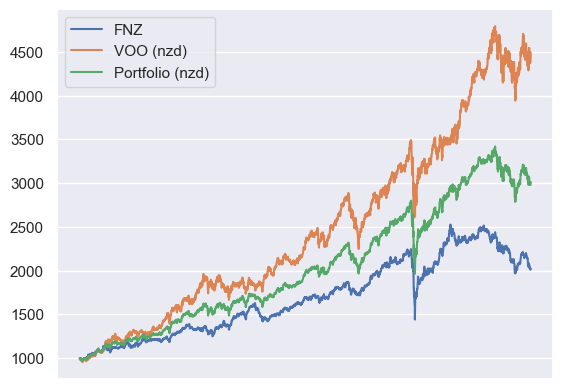

In [8]:
# plot cumulative value
ax = plt.gca()
ax.get_xaxis().set_visible(False)
FNZnzd = plt.plot(df_values.index, df_values['FNZ.NZnzd_value'], label='FNZ')
VOOnzd = plt.plot(df_values.index, df_values['VOOnzd_value'], label='VOO (nzd)')
Portfnzd = plt.plot(df_values.index, df_values['Portfnzd_value'], label='Portfolio (nzd)')
plt.legend(loc='upper left')
plt.show()

## returns covariance & correlation

In [9]:
# covariance matrix between 2 tickers and NZDUSD only 
df_returns.cov()

,FNZ.NZ,VOO,NZDUSD=X,VOOnzd,Portf_return
FNZ.NZ,0.000049,0.000021,0.000003,0.000018,0.000034
VOO,0.000021,0.000098,0.000010,0.000088,0.000054
NZDUSD=X,0.000003,0.000010,0.000035,-0.000025,-0.000011
VOOnzd,0.000018,0.000088,-0.000025,0.000113,0.000065
Portf_return,0.000034,0.000054,-0.000011,0.000065,0.000049


,FNZ.NZ,VOO,NZDUSD=X,VOOnzd,Portf_return
FNZ.NZ,1.000000,0.301496,0.078859,0.236329,0.678166
VOO,0.301496,1.000000,0.170496,0.834744,0.781919
NZDUSD=X,0.078859,0.170496,1.000000,-0.400256,-0.263343
VOOnzd,0.236329,0.834744,-0.400256,1.000000,0.874362
Portf_return,0.678166,0.781919,-0.263343,0.874362,1.000000


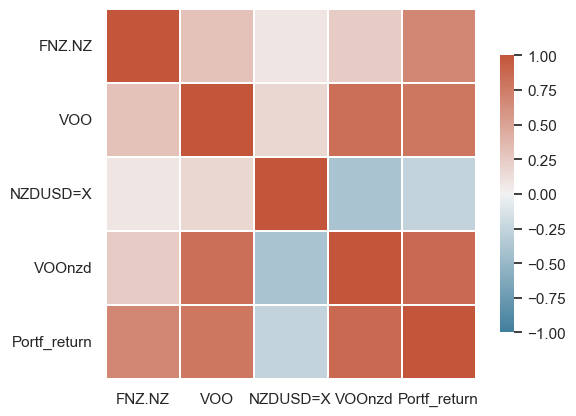

In [10]:
# correlation matrix and its heat map
display(df_returns.corr())  # value

sns.heatmap(
    data=df_returns.corr(),  
    linewidths=0.3,  # the width of lines separating the matrix squares
    square=True,   # enforce 1:1 ratios among correlation cells
    cmap=sns.diverging_palette(230, 20, as_cmap=True),  # use custom color map 
    vmax=1,  # define the max of correlation scale
    vmin=-1, # define the min of correlation scale
    center=0,  # The value at which the color map is centered about (white)
    cbar_kws={"shrink": .75}  # shrink the scale a bit
)
plt.yticks(rotation=0)  # rotate y-axis label for readability
plt.show()

# Portfolio

## Mean and Standard Deviation

In [11]:
portf_mean = df_returns['Portf_return'].mean()  # Or = df_returns[['FNZ.NZ','VOOnzd']].mean().dot([0.5,0.5])
portf_stdv = df_returns['Portf_return'].std()

print('Portfolio mean returns = ',portf_mean)
print('Portfolio s.d. returns = ',portf_stdv)

Portfolio mean returns =  0.00035603245148561706
Portfolio s.d. returns =  0.007032740006535515


$$Porfolio\ Standard\ Deviation = \sqrt{weights^T . (covariance\ matrix) . weights}$$

## Compare returns against Normal Distribution

In [12]:
def plot_vs_NormDist(df, label):
    mean = df.mean()
    sd = df.std()
    Xaxis = np.linspace(mean -3 * sd, mean +3 * sd, 1000)   # 1000 evenly spaced numbers between +/- 3 times returns' standard deviation
    plt.hist(df, alpha=0.5, bins=30, density=True, label=label)     # plot returns as histogram 
    plt.plot(Xaxis, norm.pdf(Xaxis,mean,sd), label='Normal Distribution')    # plot Normal Distribution as line. Using returns's mean & s.d.
    plt.legend()
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.show()

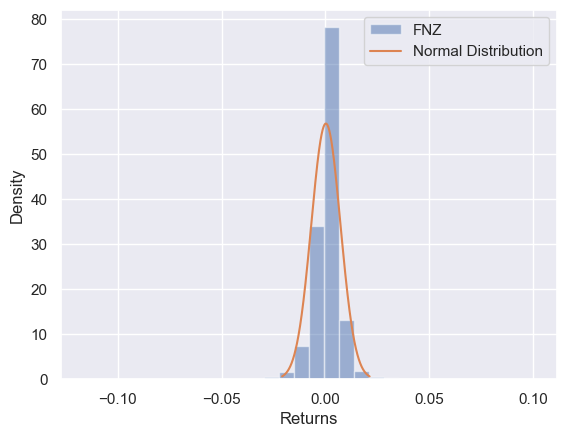

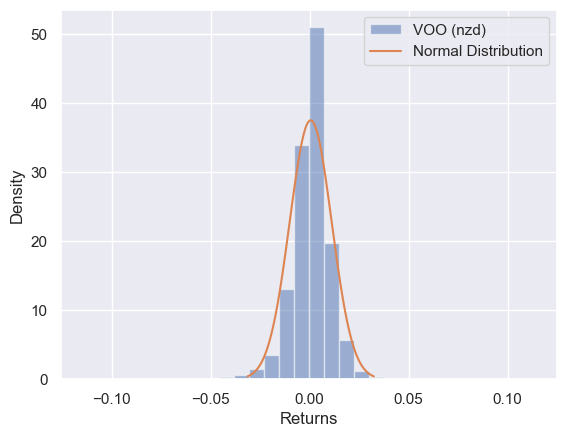

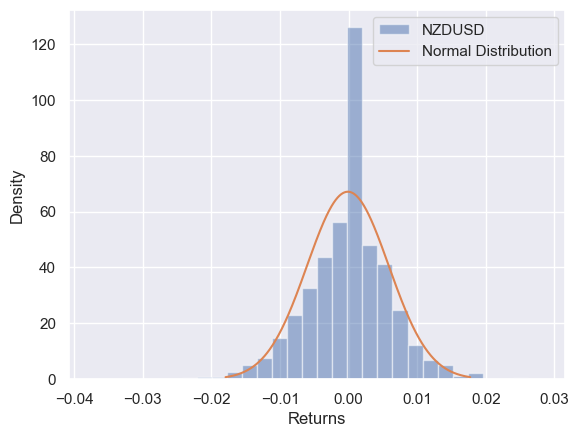

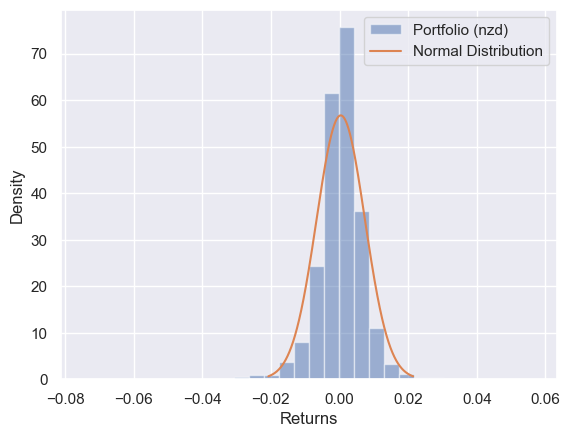

In [13]:
plot_vs_NormDist(df_returns['FNZ.NZ'], 'FNZ')
plot_vs_NormDist(df_returns['VOOnzd'], 'VOO (nzd)')
plot_vs_NormDist(df_returns['NZDUSD=X'], 'NZDUSD')
plot_vs_NormDist(df_returns['Portf_return'], 'Portfolio (nzd)')

# Parametric VaR & CVaR

In [14]:
# assume returns follow a specific distribution. Commonly Normal or t-distribution

## VaR

$$VaR\ normal\ distribution = -(mean\ - standard\ deviation * Z_a * \sqrt{days}) $$

In [15]:
# VaR = [returns' mean - (critical value of the standard normal distribution @ alpha confidence level) * returns' s.d.] * [portfolio $ value]
# VAR = [mu - ppf@confidence levl * stdev] * [portfolio $ value]
# (OPTIONAL) can take the negative value of the above to represent VaR as negative number, as a loss value
# VaR over n-day = VaR 1-day multiply by sqrt(days)
def parametric_VaR(alpha, mu, std, value, num_days, distribution='normal', dof=6):
    '''
        alpha = confidence level in decimal format (0.1, 0.95, ...)
        mu = returns' mean
        std = returns' standard deviation
        value = investment value
        num_days = nth day
        distribution = normal by default, or t-distribution
        dof = degree of freedom in case of t-distribution
    '''
    if distribution == 'normal':
        VaR = norm.ppf(alpha) * std * np.sqrt(num_days) - mu
    elif distribution == 't-distribution':
        VaR = np.sqrt((dof-2)/dof) * t.ppf(1-alpha/100, dof) * std * np.sqrt(num_days) - mu
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return abs(VaR * value)

In [16]:
# define the confidence level
conf_levels = [0.10, 0.05, 0.01]

# compute parametric VaR for given confidence levels, @ 1-day interval
parametric_VaRs = [parametric_VaR(conf_level, portf_mean, portf_stdv, invst, 1) for conf_level in conf_levels]

# print results
for i, VaR in enumerate(parametric_VaRs):
    print('Parameter VaR 1-day @ {0}%'.format((1-conf_levels[i])*100),'=', round(VaR,2))

Parameter VaR 1-day @ 90.0% = 9.37
Parameter VaR 1-day @ 95.0% = 11.92
Parameter VaR 1-day @ 99.0% = 16.72


In [17]:
# verify result 
norm.ppf(1-0.1, portf_mean, portf_stdv) * invst

9.368851416929349

In [18]:
# compute parametric VaR for given confidence levels, @ 10-day interval
parametric_VaRs = [parametric_VaR(conf_level, portf_mean, portf_stdv, invst, 10) for conf_level in conf_levels]

# print results
for i, VaR in enumerate(parametric_VaRs):
    print('Parameter VaR 10-day @ {0}%'.format((1-conf_levels[i])*100),'=', round(VaR,2))

Parameter VaR 10-day @ 90.0% = 28.86
Parameter VaR 10-day @ 95.0% = 36.94
Parameter VaR 10-day @ 99.0% = 52.09


## CVaR = Conditional VaR = ES = Expected Shortfall

In [19]:
# CVaR = probability-weighted average of tail losses
# CVaR = dividing the α tail by equal number of slices. Then estimating VaR for each slice. Then taking average of those VaR
def parametric_CVaR(alpha, mu, std, value, num_days, distribution='normal', dof=6):
    '''
        alpha = confidence level in decimal format (0.1, 0.95, ...)
        mu = returns' mean
        std = returns' standard deviation
        value = investment value
        num_days = nth day
        distribution = normal by default, or t-distribution
        dof = degree of freedom in case of t-distribution
    '''
    if distribution == 'normal':
        CVaR = (alpha)**-1 * norm.pdf(norm.ppf(alpha)) * std * np.sqrt(num_days) - mu
    elif distribution == 't-distribution':
        xanu = t.ppf(alpha, dof)
        CVaR = -1/(alpha) * (1-dof)**(-1) * (dof-2+xanu**2) * t.pdf(xanu, dof) * std * np.sqrt(num_days) - mu
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return abs(CVaR * value)

In [20]:
# compute parametric CVaR for given confidence levels, @ 1-day interval
parametric_CVaRs = [parametric_CVaR(conf_level, portf_mean, portf_stdv, invst, 1) for conf_level in conf_levels]

# print results
for i, CVaR in enumerate(parametric_CVaRs):
    print('Parameter CVaR 1-day @ {0}%'.format((1-conf_levels[i])*100),'=', round(CVaR,2))

Parameter CVaR 1-day @ 90.0% = 11.99
Parameter CVaR 1-day @ 95.0% = 14.15
Parameter CVaR 1-day @ 99.0% = 18.39


In [21]:
# compute parametric CVaR for given confidence levels, @ 10-day interval
parametric_CVaRs = [parametric_CVaR(conf_level, portf_mean, portf_stdv, invst, 10) for conf_level in conf_levels]

# print results
for i, CVaR in enumerate(parametric_CVaRs):
    print('Parameter CVaR 10-day @ {0}%'.format((1-conf_levels[i])*100),'=', round(CVaR,2))

Parameter CVaR 10-day @ 90.0% = 38.67
Parameter CVaR 10-day @ 95.0% = 45.52
Parameter CVaR 10-day @ 99.0% = 58.92


In [22]:
#NOTE: CVaR will always be higher than VaR for a given confidence level and day

## VaR & CVaR multiple days

In [23]:
# compute VaR & CVaR for multiple days: from 1 to 30 days
num_days = 30
VaR_result = []
CVaR_result = []

for conf_level in conf_levels:  # loop confidence level first, before looping days --> to make sure the result would be in ascending order
    parametric_VaRs = [parametric_VaR(conf_level, portf_mean, portf_stdv, invst, days) for days in range(1, num_days+1)]    # return of list of result for given confidence level
    VaR_result.append(parametric_VaRs)  # append result of a given confidence level to the list
        
    parametric_CVaRs = [parametric_CVaR(conf_level, portf_mean, portf_stdv, invst, days) for days in range(1, num_days+1)]
    CVaR_result.append(parametric_CVaRs)

#NOTE: VaR_result and CVaR_result consist of lists in a list [ [], [], [] ]

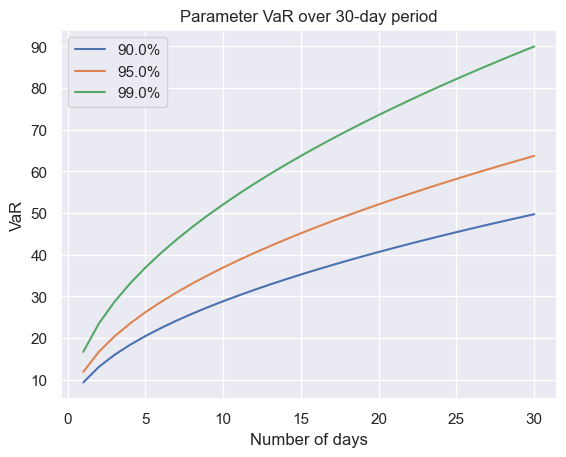

In [24]:
# plot multiple days VaR
for i, VaR in enumerate(VaR_result):    # loop through the nested lists, equivalent to the index of each confidence levels
    plt.plot(range(1, num_days+1), VaR, label='{}%'.format((1-conf_levels[i])*100))
plt.legend()
plt.xlabel('Number of days')
plt.ylabel('VaR')
plt.title('Parameter VaR over {}-day period'.format(num_days))
plt.show()

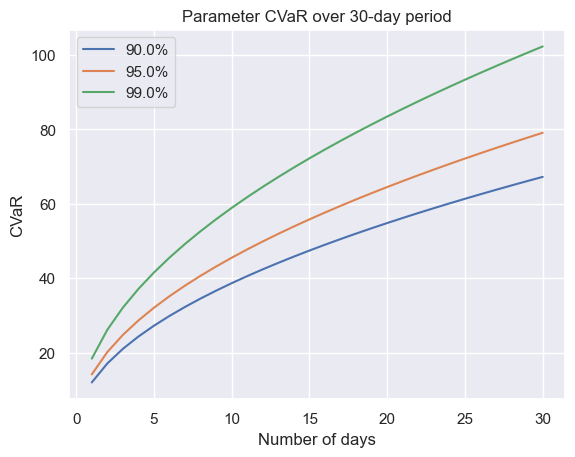

In [25]:
# plot multiple days CVaR
for i, CVaR in enumerate(CVaR_result):    # loop through the nested lists, equivalent to the index of each confidence levels
    plt.plot(range(1, num_days+1), CVaR, label='{}%'.format((1-conf_levels[i])*100))
plt.legend()
plt.xlabel('Number of days')
plt.ylabel('CVaR')
plt.title('Parameter CVaR over {}-day period'.format(num_days))
plt.show()

In [26]:
#NOTE: the lower the confidence level, the higher the potential loss --> being more left of the tail
#NOTE: the longer the computation period, the higher the potential loss

# Historical VaR & CVaR

## VaR

In [27]:
# ordering the observed returns from smallest to largest
# get the alpha-th lowest values from the sorted series. Where alpha-th = (confidence level * observations count) + 1. Round up to the nearest integer if the alpha-th result is decimal
def historical_VaR(df, alpha=95, num_days=1):
    """
        df = series of returns. Dataframe or array
        alpha = confidence level in integer
        num_days = ndays
    """
    # the np.percentile function automatically sorts from smallest to largest
    return abs(np.percentile(df, alpha) * np.sqrt(num_days))

# compute potential profit/loss for initial investment from a series of returns. Then get the profit/loss at given percentile 
histVaRs = [invst * historical_VaR(df_returns['Portf_return'], conf_level*100, num_days=1) for conf_level in conf_levels]

# print results = how much expected to lose in 1-day interval
for i, VaR in enumerate(histVaRs):
    print('Historical VaR 1-day @ {0}%'.format((1-conf_levels[i])*100),'=', round(VaR,2))

Historical VaR 1-day @ 90.0% = 6.99
Historical VaR 1-day @ 95.0% = 9.79
Historical VaR 1-day @ 99.0% = 18.57


In [28]:
# compute potential profit/loss for initial investment from a series of returns. Then get the profit/loss at given percentile 
histVaRs = [invst * historical_VaR(df_returns['Portf_return'], conf_level*100, num_days=10) for conf_level in conf_levels]

# print results = how much expected to lose in 10-day interval
for i, VaR in enumerate(histVaRs):
    print('Historical VaR 10-day @ {0}%'.format((1-conf_levels[i])*100),'=', round(VaR,2))

Historical VaR 10-day @ 90.0% = 22.1
Historical VaR 10-day @ 95.0% = 30.97
Historical VaR 10-day @ 99.0% = 58.73


## CVaR

In [29]:
# ordering the observed returns from smallest to largest
# compute all profit/loss for all return points below given confidence interval
# take average of those profit/loss

def historical_CVaR(df, alpha=95, num_days=1):
    """
        df = series of returns. Dataframe or array
        alpha = confidence level in integer
        num_days = ndays
    """
    belowVaR = df[df < np.percentile(df, alpha)]
    meanBelowVaR = belowVaR.mean()
    return abs(meanBelowVaR * np.sqrt(num_days))

# compute potential profit/loss for initial investment from a series of returns. Then get the profit/loss at given percentile 
histCVaRs = [invst * historical_CVaR(df_returns['Portf_return'], conf_level*100, num_days=1) for conf_level in conf_levels]

# print results = how much expected to lose in 1-day interval
for i, VaR in enumerate(histCVaRs):
    print('Historical CVaR 1-day @ {0}%'.format((1-conf_levels[i])*100),'=', round(VaR,2))

Historical CVaR 1-day @ 90.0% = 12.49
Historical CVaR 1-day @ 95.0% = 16.71
Historical CVaR 1-day @ 99.0% = 30.65


In [30]:
# compute potential profit/loss for initial investment from a series of returns. Then get the profit/loss at given percentile 
histCVaRs = [invst * historical_CVaR(df_returns['Portf_return'], conf_level*100, num_days=10) for conf_level in conf_levels]

# print results = how much expected to lose in 10-day interval
for i, VaR in enumerate(histCVaRs):
    print('Historical CVaR 10-day @ {0}%'.format((1-conf_levels[i])*100),'=', round(VaR,2))

Historical CVaR 10-day @ 90.0% = 39.5
Historical CVaR 10-day @ 95.0% = 52.86
Historical CVaR 10-day @ 99.0% = 96.94


## Plot returns

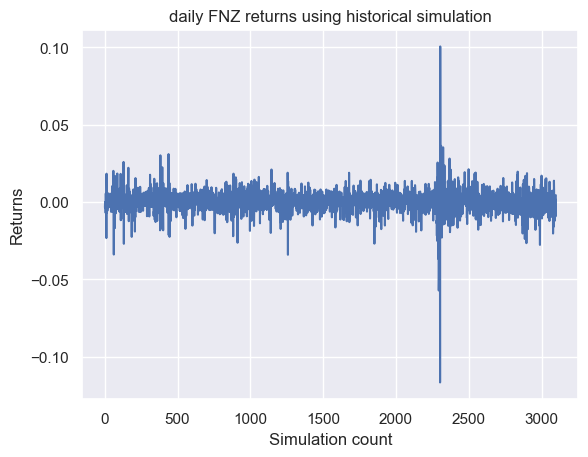

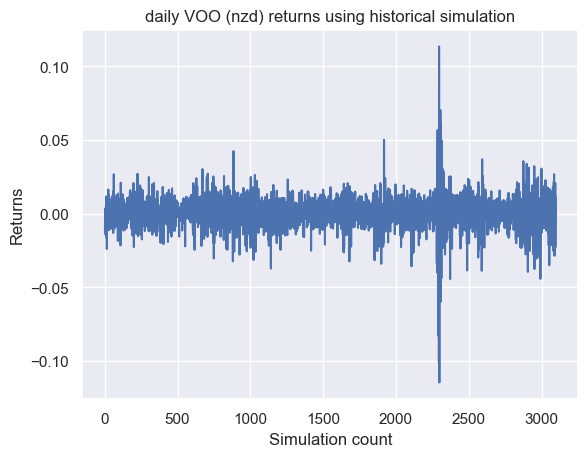

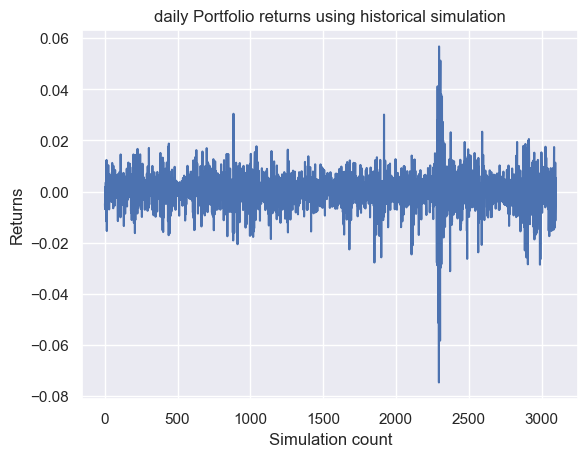

In [37]:
# plot historical returns
plt.plot(range(1, len(df_returns)+1), df_returns['FNZ.NZ'])
plt.ylabel('Returns')
plt.xlabel('Simulation count')
plt.title('daily FNZ returns using historical simulation')
plt.show()

plt.plot(range(1, len(df_returns)+1), df_returns['VOOnzd'])
plt.ylabel('Returns')
plt.xlabel('Simulation count')
plt.title('daily VOO (nzd) returns using historical simulation')
plt.show()


plt.plot(range(1, len(df_returns)+1), df_returns['Portf_return'])
plt.ylabel('Returns')
plt.xlabel('Simulation count')
plt.title('daily Portfolio returns using historical simulation')
plt.show()

#NOTE: max & min returns of Portfolio is less than max & min returns of individual stock FNZ and VOO. Emphasize the diversification benefit

# Historical Bootstrap VaR & CVaR

In [46]:
randomised_returns = []
bootstrap_returns = []
#NOTE: REDO

# for _ in range(len(df_returns)):
#     for _ in range(num_days):
#         random_idx = np.random.choice(len(df_returns))
#         randomised_returns.append(df_returns.iloc[random_idx,:].values)
#     bootstrap_returns.append(randomised_returns)

# len(np.array(bootstrap_returns))

3098

# Monte Carlo simulation

In [259]:
# Monte Carlo simulation to simulate potential future values 
def MCsimulation(df, invest_amt, weight, portf_name='Portfolio', num_simulation=500, simul_days=30, plot=True):
    """
        df = dataframe of returns
        invest_amt = investment amount
        weight = weight of each investment. = 1 if only 1 investment. = [0.6, 0.4] for 2 investments.
        portf_name = name for the chart title
        num_simulation = number of simulation
        simul_days = number of days for each simulation
        plot = whether to plot simulation results or not
    """
    # check type of input data before doing calculation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expect a pandas Dataframe in the first input")
    if not isinstance(weight, list):
        raise TypeError("Expect a list in the third input")
    else:
        df_simulations = pd.DataFrame()     # empty df to store simulation result
        value_start_indiv = invest_amt * np.array(weight) * (1+df.iloc[-1])   # initial value of each investment = investment amount * weight of each investment * last return value
        value_start_portf = sum(value_start_indiv)  # initial value of portfolio = sum(initial value of each investment)

        # loop for each simulation
        for sim in range(num_simulation):
            sim_indiv = value_start_indiv.to_numpy()
            sim_portf = [value_start_portf]     # from begining of each simulation, restart portfolio value to value_start_portf above. Put it in a list
            
            # loop for each day
            for day in range(simul_days):
                zero_mean = np.full(shape=(df.shape[1]), fill_value=0.0)    # create an array, where shape = number of investment of the returns' dataframe. Fill its value with zero.  
                sim_returns = np.random.multivariate_normal(zero_mean, df.cov())    # random samples from multivariate normal distribution. With mean of 0, and covariance = covariance of the returns
                sim_indiv = sim_indiv*(1 + sim_returns)     # multiply this return to the value of each individual investment. Reuse this value for each day --> to have a series of individual values 
                sim_portf.append(sum(sim_indiv))    # sum up the new individual value to get portfolio value. Append this new portfolio value to the simulation portfolio list. 

            df_simulations = pd.concat([df_simulations, pd.DataFrame(sim_portf)], axis=1)     # append cumulated values of portfolio in the simulation to simulation result df

        # if plot simulation results = True
        if plot:
            plt.plot(df_simulations) 
            plt.xlabel('Days in future')
            plt.ylabel('Portfolio Value')
            plt.title('Monte Carlo Simulation {0} Value'.format(portf_name), fontsize=14, fontweight='bold')
            plt.show() 
    
    return df_simulations

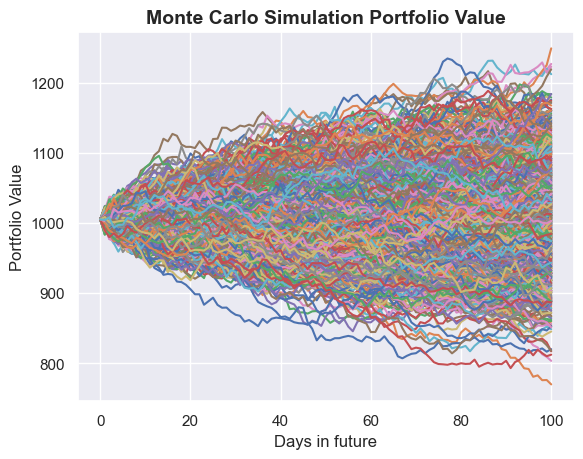

In [260]:
simul_days = 100
dfsim = MCsimulation(
    df=df_returns[['Portf_return']], 
    invest_amt=invst, 
    weight = [1], 
    portf_name='Portfolio', 
    num_simulation=1000, 
    simul_days=simul_days, 
    plot=True)

## VaR

In [261]:
# calculate VaR from the last row of the simulation df <-- i.e. the last simulated day, as specified in the simulation formula
nth_day_value = dfsim.iloc[-1,:]

# use the historical_VaR() above to compute potential investment value on the n-th day. Then deduct that from the initial investment value to get the profit/loss at given percentile 
montecarloVaRs = [invst - historical_VaR(nth_day_value, conf_level*100, num_days=1) for conf_level in conf_levels]

# print results = how much expected to lose in 1-day interval
for i, VaR in enumerate(montecarloVaRs):
    print('Monte Carlo VaR 1-day @ {0}%'.format((1-conf_levels[i])*100),'=', round(VaR,2))

#NOTE: because the simulation above is one day at a time, so not make sense to compute VaR for more than 1 day.

Monte Carlo VaR 1-day @ 90.0% = 85.55
Monte Carlo VaR 1-day @ 95.0% = 108.95
Monte Carlo VaR 1-day @ 99.0% = 147.42


## CVaR

In [262]:
# use the historical_CVaR() above to compute potential investment value on the n-th day. Then deduct that from the initial investment value to get the profit/loss at given percentile 
montecarloCVaRs = [invst - historical_CVaR(nth_day_value, conf_level*100, num_days=1) for conf_level in conf_levels]

# print results = how much expected to lose in 1-day interval
for i, VaR in enumerate(montecarloCVaRs):
    print('Monte Carlo CVaR 1-day @ {0}%'.format((1-conf_levels[i])*100),'=', round(VaR,2))

Monte Carlo CVaR 1-day @ 90.0% = 115.3
Monte Carlo CVaR 1-day @ 95.0% = 133.08
Monte Carlo CVaR 1-day @ 99.0% = 176.19


## Plot returns

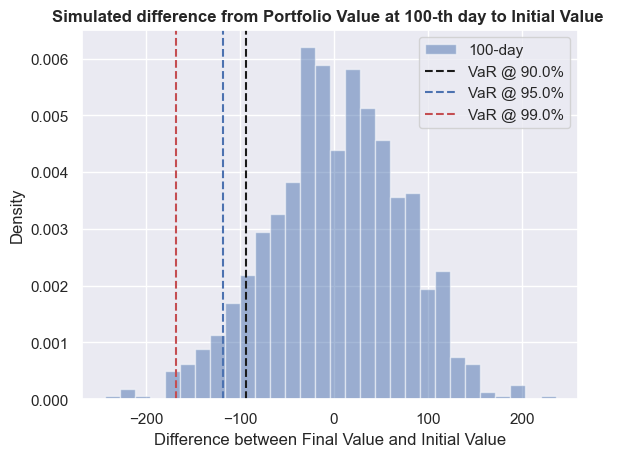

In [267]:
diff_vals = dfsim.iloc[0] - dfsim.iloc[simul_days]      # compute all difference in (initial investment value minus final investment value) for each simulation
plt.hist(diff_vals, density=True, alpha=0.5, label='{}-day'.format(simul_days), bins=30)    # plot value difference in histogram

# plot VaR value as vertical line
colors = ['k', 'b', 'r']
for idx, conf_level in enumerate(conf_levels):
    plt.axvline(np.percentile(diff_vals, conf_level * 100), color=colors[idx], linestyle='--', label='VaR @ {0}%'.format((1-conf_level)*100))

plt.xlabel('Difference between Final Value and Initial Value')
plt.ylabel('Density')
plt.legend()
plt.title('Simulated difference from Portfolio Value at {0}-th day to Initial Value '.format(simul_days), fontsize=12, fontweight='bold')
plt.show()